In [1]:
import os, shutil, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # if we have only one GPU, otherwise "0, 1, etc"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13560647090548488467
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15816909837990409029
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2471221069787608891
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10943175066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5184528447888262024
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
from PIL import Image
import random
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils 

# import keras
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers 

print(tf.__version__)

#scratch-shared/maris/tests/labels.csv
#scratch-shared/maris/tests/MiCoPh_Image_0_255
#scratch-shared/maris/tests/MiSyHo_Image_0_255

2.1.0


In [3]:
basedir1 = input("Enter first directory name of images: ") # e.g.  /home/jovyan/scratch-shared/maris/tests/MiCoPh_Image_0_255

Enter first directory name of images:  /home/jovyan/scratch-shared/maris/tests/MiCoPh_Image_0_255


In [4]:
print(len(os.listdir(basedir1)))

12301


In [5]:
basedir2 = input("Enter second directory name of images: ") # e.g. /home/jovyan/scratch-shared/maris/tests/MiSyHo_Image_0_255

Enter second directory name of images:  /home/jovyan/scratch-shared/maris/tests/MiSyHo_Image_0_255


In [6]:
print(len(os.listdir(basedir2)))

12301


In [7]:
df=pd.read_csv('/home/jovyan/scratch-shared/maris/tests/labels.csv', sep=';')
df.columns = ['nr','plate','well',
                     'site','type','compoundname','target','concentration']
df.fillna("NotKnown", inplace = True)

df["target"] = df["target"].str.replace(' ', '') #remove spaces
df["target"] = df["target"].str.replace('c-Kit', 'cKit') #
df["target"] = df["target"].str.replace('GSK-3', 'GSK3') #
df["target"] = df["target"].str.replace('VEGFR', 'VEGrFR') #so that string EGFR is not in VEGFR
df['target'] = np.where((df['type'] == 'control'), df['type'] , df['target'])

df["filename"] = df["nr"].astype(str) + ".png"

df

,nr,plate,well,site,type,compoundname,target,concentration,filename
0,0,P009063,B02,1,compound,CBK013405,EGFR,10,0.png
1,1,P009063,B02,2,compound,CBK013405,EGFR,10,1.png
2,2,P009063,B02,3,compound,CBK013405,EGFR,10,2.png
3,3,P009063,B02,4,compound,CBK013405,EGFR,10,3.png
4,4,P009063,B02,5,compound,CBK013405,EGFR,10,4.png
...,...,...,...,...,...,...,...,...,...
12295,12295,P009083,G11,5,compound,CBK293913C,Rho,4,12295.png
12296,12296,P009083,G11,6,compound,CBK293913C,Rho,4,12296.png
12297,12297,P009083,G11,7,compound,CBK293913C,Rho,4,12297.png
12298,12298,P009083,G11,8,compound,CBK293913C,Rho,4,12298.png


In [8]:
activities = sorted(list(set(df['target']))) 
for a in activities:
    if ',' in a:
        df[a] = [1 if a == x else 0 for x in df['target']]
    else:
        df[a] = [1 if a in x else 0 for x in df['target']] # COMPOUNDS THAT HAVE SEVERAL TARGETS GET VALUE 1 FOR EACH TARGET
print(activities)

['ALK', 'AMPK', 'ATM', 'ATM/ATR', 'Akt', 'Akt,CDK,PKA', 'Akt,MEK', 'Akt,PDK-1', 'Akt,S6kinase', 'AuroraKinase', 'AuroraKinase,FGFR,Bcr-Abl,c-RET,Src', 'AuroraKinase,VEGrFR', 'BTK', 'Bcr-Abl', 'Bcr-Abl,JAK,AuroraKinase', 'Bcr-Abl,VEGrFR,FGFR,PDGFR,Flt', 'CDK', 'CDK,AuroraKinase', 'CHK', 'Chk', 'DNA-PK,PI3K', 'DNA-PK,PI3K,mTOR', 'DNA-PK,mTOR,PDGF', 'DUB,Bcr-Abl', 'EGFR', 'EGFR,Flt,VEGrFR,HER2', 'EGFR,HER2', 'EGFR,mTOR', 'ERK', 'FAK', 'FGFR', 'FGFR,VEGrFR', 'FLT3', 'Flt', 'Flt,AuroraKinase,VEGrFR', 'Flt,Bcr-Abl,AuroraKinase', 'Flt,FGFR,PDGFR,VEGrFR,cKit', 'Flt,JAK,c-RET', 'FreeBase', 'GSK3', 'HDAC,EGFR,HER2', 'HDAC,PI3K', 'HER2', 'HER2,EGFR', 'IA/ASB/IKK', 'IGF-1,ALK', 'IGF-1R', 'IKK', 'I¦ÊB/IKK', 'JAK', 'JAK,EGFR', 'JNK', 'LRRK2', 'MEK', 'NotKnown', 'Others', 'PAK', 'PDGFR', 'PDGFR,VEGrFR', 'PDGFR,cKit,Bcr-Abl', 'PDK-1', 'PDK-1,IKK', 'PI3K', 'PI3K,DNA-PK', 'PI3K,PKC,Src,Sirtuin', 'PI3K,VEGrFR', 'PI3K,mTOR', 'PI3K/Akt/mTOR', 'PKC', 'PLK', 'Pim', 'ProductCategoriesPI3K/Akt/mTORPI3KPI3K', '

In [9]:
nrclasses = len(activities)
nrclasses

115

In [10]:
df = df[df.NotKnown != 1]
df = df.drop(columns='NotKnown')
activities.remove('NotKnown')
df

,nr,plate,well,site,type,compoundname,target,concentration,filename,ALK,...,c-Myc,"cKit,FGFR,Flt,VEGrFR,PDGFR","cKit,PDGFR,FGFR,FAK","cKit,Raf,VEGrFR","cKit,VEGrFR",control,mTOR,"mTOR,PI3K","mTOR,PI3K,Akt",p38MAPK
0,0,P009063,B02,1,compound,CBK013405,EGFR,10,0.png,0,...,0,0,0,0,0,0,0,0,0,0
1,1,P009063,B02,2,compound,CBK013405,EGFR,10,1.png,0,...,0,0,0,0,0,0,0,0,0,0
2,2,P009063,B02,3,compound,CBK013405,EGFR,10,2.png,0,...,0,0,0,0,0,0,0,0,0,0
3,3,P009063,B02,4,compound,CBK013405,EGFR,10,3.png,0,...,0,0,0,0,0,0,0,0,0,0
4,4,P009063,B02,5,compound,CBK013405,EGFR,10,4.png,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,12295,P009083,G11,5,compound,CBK293913C,Rho,4,12295.png,0,...,0,0,0,0,0,0,0,0,0,0
12296,12296,P009083,G11,6,compound,CBK293913C,Rho,4,12296.png,0,...,0,0,0,0,0,0,0,0,0,0
12297,12297,P009083,G11,7,compound,CBK293913C,Rho,4,12297.png,0,...,0,0,0,0,0,0,0,0,0,0
12298,12298,P009083,G11,8,compound,CBK293913C,Rho,4,12298.png,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
nrclasses = len(activities)
nrclasses

114

In [12]:
df['plate_well'] = df['plate'] + df['well']
welllist = sorted(list(set(df['plate_well'])))
print(len(welllist))
print(welllist[0:5])

def partitions (list_in, n):
    random.seed(1)
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

chunks = partitions(welllist, 5) #split the dataset in 5 folds excluding 20% of images (a better way to validate would be excluding 20% of wells)
#print (chunks[0])
len(chunks)
df1=df[~df['plate_well'].isin(chunks[0])]
df2=df[df['plate_well'].isin(chunks[0])]
print(len(set(df1['nr'])))
print(len(df2))

1253
['P009063B02', 'P009063B03', 'P009063B04', 'P009063B05', 'P009063B06']
9738
2499


In [13]:
df1=df1.sort_values(by="filename") 
df1=df1.reset_index()

df2=df2.sort_values(by="filename")
df2=df2.reset_index()
df2.head()

,index,nr,plate,well,site,type,compoundname,target,concentration,filename,...,"cKit,FGFR,Flt,VEGrFR,PDGFR","cKit,PDGFR,FGFR,FAK","cKit,Raf,VEGrFR","cKit,VEGrFR",control,mTOR,"mTOR,PI3K","mTOR,PI3K,Akt",p38MAPK,plate_well
0,10014,10014,P009079,F08,1,control,DMSO,control,10,10014.png,...,0,0,0,0,1,0,0,0,0,P009079F08
1,10015,10015,P009079,F08,2,control,DMSO,control,10,10015.png,...,0,0,0,0,1,0,0,0,0,P009079F08
2,10016,10016,P009079,F08,3,control,DMSO,control,10,10016.png,...,0,0,0,0,1,0,0,0,0,P009079F08
3,10017,10017,P009079,F08,4,control,DMSO,control,10,10017.png,...,0,0,0,0,1,0,0,0,0,P009079F08
4,10018,10018,P009079,F08,5,control,DMSO,control,10,10018.png,...,0,0,0,0,1,0,0,0,0,P009079F08


In [14]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

def weighted_loss(y_true, y_pred):
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)

import tensorflow.keras.losses
keras.losses.weighted_loss = weighted_loss

class_weights = calculating_class_weights(df[activities].values)
print (class_weights)

scaling = 0 # some number between 0 and 1; if 0, no scaling is performed
class_weights_scaled = class_weights**scaling
print (class_weights_scaled) 

[[  0.50557759  45.32222222]
 [  0.50445214  56.65277778]
 [  0.50670807  37.76851852]
 [  0.50445214  56.65277778]
 [  0.51803404  14.36267606]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.52645844   9.94878049]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50333169  75.53703704]
 [  0.52041337  12.746875  ]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.52523822  10.40561224]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50445214  56.65277778]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.5402649    6.70888158]
 [  0.50110565 226.61111111]
 [  0.50759084  33.43442623]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50445214  56.65277778]
 [  0.51476527  17.43162393]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.5171146   15.10740741]
 [  0.50110565

In [15]:
datagen= ImageDataGenerator(rescale=(1./255), horizontal_flip=True, vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255.)

classes = None
#target_size = 270, 270
target_size = 224, 224 #input size for MobileNet and MobileNetV2
x_col = 'filename'
y_col = activities

train_generator1=datagen.flow_from_dataframe(
dataframe=df1,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
classes = classes,
interpolation = "lanczos",
target_size=target_size)

validation_generator1=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

test_generator1=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
interpolation = "lanczos",
target_size=target_size)

train_generator2=datagen.flow_from_dataframe(
dataframe=df1,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

validation_generator2=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

test_generator2=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
interpolation = "lanczos",
target_size=target_size)

Found 9738 validated image filenames.
Found 2499 validated image filenames.
Found 2499 validated image filenames.
Found 9738 validated image filenames.
Found 2499 validated image filenames.
Found 2499 validated image filenames.


In [16]:
#def doubleGenerator(generator1,generator2):
 #   while True:
  #      for (x1,y1),(x2,y2) in zip(generator1,generator2):
   #         yield (np.concatenate((x1,x2[:,:,:,1:]), axis=3),y1)

In [16]:
def doubleGenerator(generator1,generator2): #for 2 networks with 3 channels each
    while True:
        for (x1,y1),(x2,y2) in zip(generator1,generator2):
            yield ([x1,x2],y1)

## Mobile Nets

In [29]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [30]:
pre_trained_model1 = MobileNetV2(input_shape=(224,224,3), include_top=False,  weights='imagenet')
# pre_trained_model1.summary()

In [31]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [32]:
pre_trained_model2 = MobileNet(input_shape=(224,224,3), include_top=False,  weights='imagenet')

In [33]:
last_output1 = pre_trained_model1.output
last_output2 = pre_trained_model2.output
print ('Pre-trained network 1: last layer output shape:', last_output1.shape)
print ('Pre-trained network 2: last layer output shape:', last_output2.shape)

Pre-trained network 1: last layer output shape: (None, 7, 7, 1280)
Pre-trained network 2: last layer output shape: (None, 7, 7, 1024)


In [34]:
for layer in pre_trained_model1.layers:   #True is default. Can be changed to False
  layer.trainable = True
for layer in pre_trained_model2.layers:
  layer.trainable = True

In [35]:
#pre_trained_model1.summary()

In [36]:
x1 = layers.GlobalAveragePooling2D(name='avg_pool1')(last_output1)
x2 = layers.GlobalAveragePooling2D(name='avg_pool2')(last_output2)

In [37]:
#Concatenate dense layers of the two networks
xmerged = layers.concatenate(axis=-1, inputs=[x1, x2])
# Add a dropout rate of 0.5
xmerged = layers.Dropout(0.5)(xmerged)
x = layers.Dense(512, activation='relu')(xmerged) # is it needed?

# Create output layer with n_classes nodes and sigmoid activation
output = layers.Dense(nrclasses, activation='sigmoid')(x) 

In [38]:
model = Model(inputs=[pre_trained_model1.input, pre_trained_model2.input], outputs=[output])

try:
    model = multi_gpu_model(model, gpus=2)
    print ('Using 2 GPUs')
except:
    print ("No more than 1 GPU available")
    
#model.compile(optimizers.SGD(lr=0.00001, decay=1e-6), loss='binary_crossentropy', metrics = ['acc']) 
model.compile(loss='binary_crossentropy',  optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['acc'])



Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
No more than 1 GPU available


In [39]:
# model.summary()
# pre_trained_model1.input

In [40]:
STEP_SIZE_TRAIN=train_generator1.n//train_generator1.batch_size
STEP_SIZE_VALID=validation_generator1.n//validation_generator1.batch_size
STEP_SIZE_TEST=test_generator1.n//test_generator1.batch_size

In [41]:
# checkpoint for saving models (best model or all of them if save_best_only=False)
checkpointer = tf.keras.callbacks.ModelCheckpoint('ModelMay8-{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
                               monitor='val_loss', verbose=0,
                                save_best_only=False, save_weights_only=False, mode='auto')

In [42]:
epochs = 10

In [43]:
history = model.fit_generator(generator=doubleGenerator(train_generator1, train_generator2),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=doubleGenerator(validation_generator1, validation_generator2),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = [checkpointer]
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 2499 steps
Epoch 1/10
304/304 [==============================] - 516s 2s/step - loss: 0.0853 - acc: 0.9754 - val_loss: 0.0679 - val_acc: 0.9876
Epoch 2/10
304/304 [==============================] - 446s 1s/step - loss: 0.0513 - acc: 0.9873 - val_loss: 0.0579 - val_acc: 0.9876
Epoch 3/10
304/304 [==============================] - 445s 1s/step - loss: 0.0457 - acc: 0.9878 - val_loss: 0.0653 - val_acc: 0.9868
Epoch 4/10
304/304 [==============================] - 446s 1s/step - loss: 0.0408 - acc: 0.9882 - val_loss: 0.0579 - val_acc: 0.9870
Epoch 5/10
304/304 [==============================] - 445s 1s/step - loss: 0.0367 - acc: 0.9887 - val_loss: 0.0545 - val_acc: 0.9873
Epoch 6/10
304/304 [==============================] - 446s 1s/step - loss: 0.0327 - acc: 0.9895 - val_loss: 0.0522 - val_acc: 0.9878
Epoch 7/10
304/304 [===========

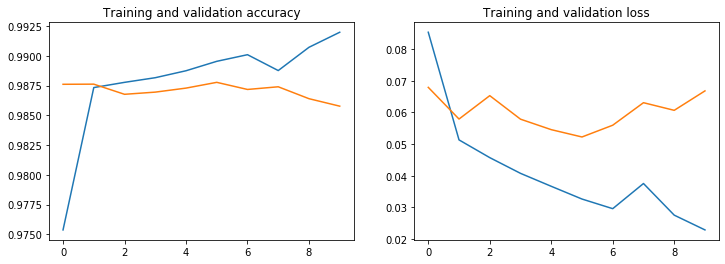

In [64]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

#Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc)
ax1.plot(epochs, val_acc)
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss)
ax2.plot(epochs, val_loss)
ax2.set_title('Training and validation loss')

fig.savefig('loss_vgg16_pretrained_adam_lr0.0001_batch32.png', dpi=300) # SAVE FIGURE

In [53]:
test_generator1.reset()
test_generator2.reset()
predictions = model.predict_generator(doubleGenerator(test_generator1, test_generator2), verbose=1, steps=test_generator1.samples/test_generator1.batch_size)

2499/2499 [==============================] - 116s 46ms/step


In [54]:
print(predictions[:,0:5])

[[1.6420697e-03 6.6670198e-03 9.9127479e-03 3.9071076e-02 5.6696692e-03]
 [1.1107202e-03 2.7392130e-02 5.1683729e-04 1.7584437e-03 1.9421402e-02]
 [1.0345550e-03 5.7970405e-02 8.9453177e-05 2.9987266e-04 3.1773143e-02]
 ...
 [6.3017738e-04 5.8085693e-04 2.9014150e-04 4.2303037e-04 3.1640199e-01]
 [5.8912515e-04 1.4990443e-04 1.6764790e-05 5.3943037e-05 2.1060589e-03]
 [4.1659712e-04 1.5177201e-04 1.5102431e-07 5.9733520e-06 2.9679283e-03]]


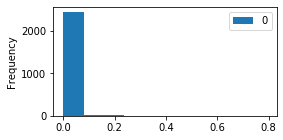

In [55]:
pd.DataFrame(predictions[:,0]).plot(kind='hist', figsize=(4, 2))

In [56]:
y = df2[activities].values
y.shape

(2499, 114)

In [65]:
auc_of_models = pd.DataFrame(columns = ['target/activity', 'roc area'])

for i in range(nrclasses):
    try:
        roc_auc = (roc_auc_score(y[:,i], predictions[:,i]))
        print("roc_auc for class '%s'" % activities[i], roc_auc)
    except:
        continue
        
auc_of_models.to_csv('rocauc_vgg16_pretrained_adam_lr0.0001_batch32.csv', sep=',') #SAVE ROC_AUC

roc_auc for class 'ALK' 0.9520303435966088
roc_auc for class 'AMPK' 0.8626842862279755
roc_auc for class 'ATM' 0.8503835550761116
roc_auc for class 'ATM/ATR' 0.956267634018541
roc_auc for class 'Akt' 0.8944264659175772
roc_auc for class 'Akt,PDK-1' 0.9839357429718876
roc_auc for class 'Akt,S6kinase' 0.9548862115127175
roc_auc for class 'AuroraKinase' 0.9258162311950628
roc_auc for class 'AuroraKinase,FGFR,Bcr-Abl,c-RET,Src' 0.933020972780009
roc_auc for class 'BTK' 0.8360428142773971
roc_auc for class 'Bcr-Abl' 0.6751590898686077
roc_auc for class 'CDK' 0.8496749057766988
roc_auc for class 'CDK,AuroraKinase' 0.9570281124497992
roc_auc for class 'CHK' 0.9998661311914323
roc_auc for class 'Chk' 0.9521904590674817
roc_auc for class 'DNA-PK,PI3K,mTOR' 0.8072289156626506
roc_auc for class 'DUB,Bcr-Abl' 0.991120035698349
roc_auc for class 'EGFR' 0.758047370096856
roc_auc for class 'EGFR,HER2' 0.9052236732425674
roc_auc for class 'ERK' 0.9975457385095939
roc_auc for class 'FAK' 0.856804997768

In [66]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nrclasses):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [67]:
print(roc_auc["micro"])

0.9039001994712204


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


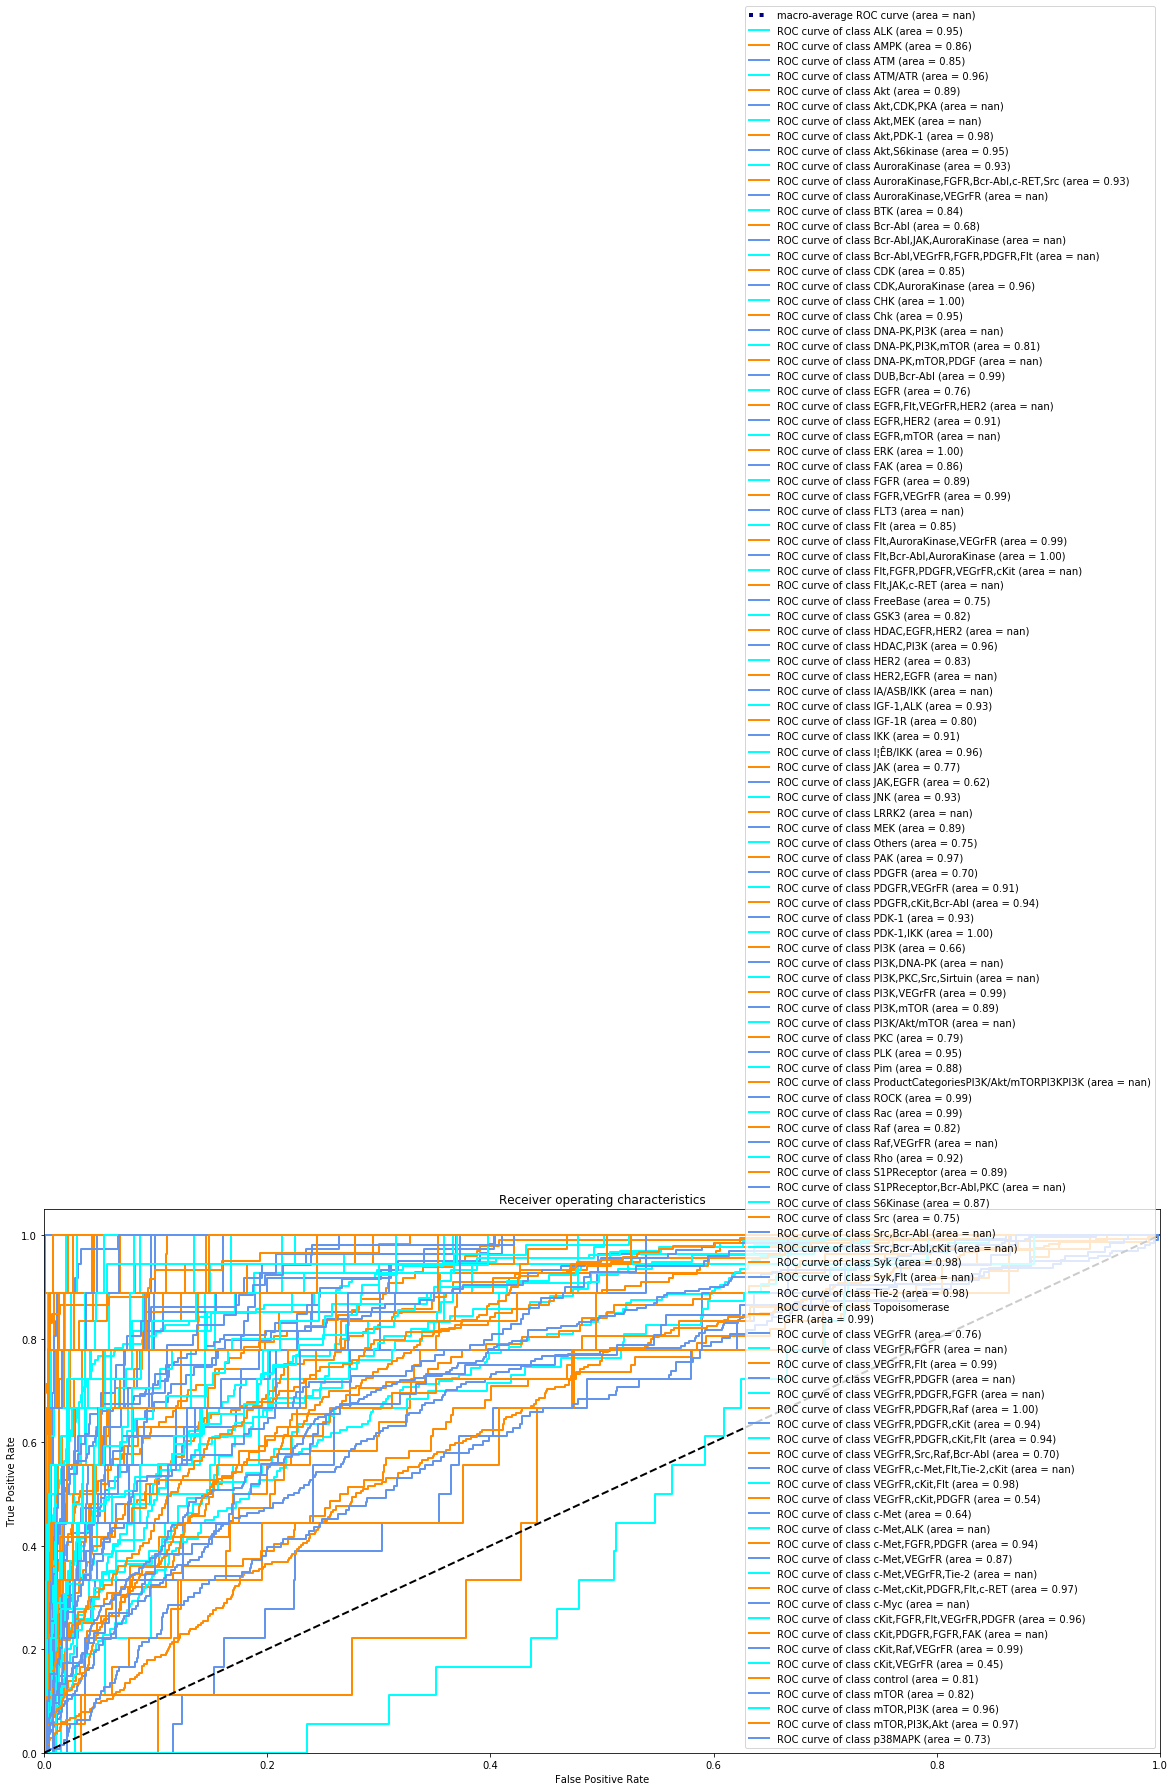

<Figure size 1440x720 with 0 Axes>

In [68]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nrclasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nrclasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nrclasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nrclasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(activities[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

plt.savefig('rocauc_vgg16_pretrained_adam_lr0.0001_batch32.png', dpi=300) # SAVE FIGURE

In [32]:
img_input = layers.Input(shape=(224,224,3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [33]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
# x = layers.Flatten()(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create a fully connected layer with ReLU activation and 512 hidden units # needed???
# x = layers.Dense(512, activation='relu')(x)

# Create output layer
output = layers.Dense(nrclasses, activation='sigmoid')(x)

In [34]:
model = Model(img_input, output)

try:
    model = multi_gpu_model(model, gpus=2)
    print ('Using 2 GPUs')
except:
    print ("No more than 1 GPU available")
    
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6), loss='binary_crossentropy', metrics = ['acc'])
# or, if we have not defined a custom loss function
# model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6), loss='binary_crossentropy', metrics = ['acc'])

No more than 1 GPU available


In [31]:
model = Model(inputs=[pre_trained_model1.input, pre_trained_model2.input], outputs=[output])

try:
    model = multi_gpu_model(model, gpus=2)
    print ('Using 2 GPUs')
except:
    print ("No more than 1 GPU available")
    
model.compile(optimizers.RMSprop(lr=0.00003, decay=1e-6), loss='binary_crossentropy', metrics = ['acc']) 
#model.compile(loss='binary_crossentropy',  optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['acc'])


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_3:0", shape=(None, 270, 270, 5), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: []

In [31]:
# model.summary()

In [35]:
STEP_SIZE_TRAIN=train_generator1.n//train_generator1.batch_size
STEP_SIZE_VALID=validation_generator1.n//validation_generator1.batch_size
STEP_SIZE_TEST=test_generator1.n//test_generator1.batch_size

In [36]:
print(tf.__version__)


2.1.0


In [37]:
import keras_preprocessing 

In [38]:
print(keras_preprocessing.__version__)
dir(test_generator1)

1.1.0


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_params',
 '_filepaths',
 '_filter_classes',
 '_filter_valid_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_sample_weight',
 '_set_index_array',
 '_targets',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_mode',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'get_classes',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'on_epoch_end',
 'reset',
 'sample_weight

In [39]:
print(keras.__version__)

2.2.4-tf


In [40]:
# checkpoint for saving models (best model or all of them if save_best_only=False)
checkpointer = tf.keras.callbacks.ModelCheckpoint('Model-{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
                               monitor='val_loss', verbose=0,
                                save_best_only=False, save_weights_only=False, mode='auto')

In [41]:
epochs = 10

In [42]:
history = model.fit_generator(generator=doubleGenerator(train_generator1, train_generator2),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=doubleGenerator(validation_generator1, validation_generator2),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = [checkpointer]
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 307 steps, validate for 2459 steps
Epoch 1/10
307/307 [==============================] - 505s 2s/step - loss: 0.4236 - acc: 0.8955 - val_loss: 0.3847 - val_acc: 0.8918
Epoch 2/10
307/307 [==============================] - 435s 1s/step - loss: 0.3702 - acc: 0.9032 - val_loss: 0.3617 - val_acc: 0.8918
Epoch 3/10
307/307 [==============================] - 415s 1s/step - loss: 0.3380 - acc: 0.9023 - val_loss: 0.3318 - val_acc: 0.8918
Epoch 4/10
307/307 [==============================] - 433s 1s/step - loss: 0.3302 - acc: 0.9022 - val_loss: 0.3236 - val_acc: 0.8918
Epoch 5/10
307/307 [==============================] - 424s 1s/step - loss: 0.3202 - acc: 0.9026 - val_loss: 0.3215 - val_acc: 0.8918
Epoch 6/10
307/307 [==============================] - 415s 1s/step - loss: 0.3158 - acc: 0.9036 - val_loss: 0.3202 - val_acc: 0.8918
Epoch 7/10
307/307 [===========

Text(0.5, 1.0, 'Training and validation loss')

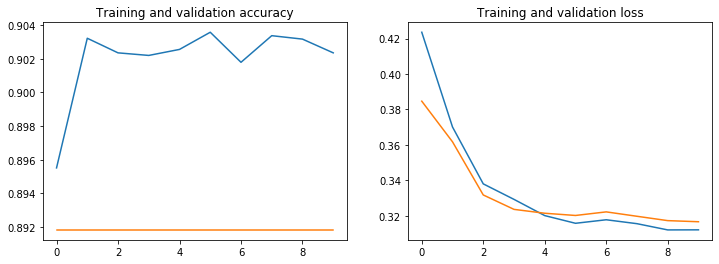

In [43]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

#Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc)
ax1.plot(epochs, val_acc)
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss)
ax2.plot(epochs, val_loss)
ax2.set_title('Training and validation loss')


In [44]:
test_generator1.reset()
test_generator2.reset()
predictions = model.predict_generator(doubleGenerator(test_generator1, test_generator2), verbose=1, steps=test_generator1.samples/test_generator1.batch_size)

Instructions for updating:
Please use Model.predict, which supports generators.
2459/2459 [==============================] - 103s 42ms/step


In [45]:
print(predictions[:,0])

[0.81741685 0.84680384 0.88414603 ... 0.967368   0.85838544 0.89510393]


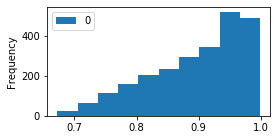

In [46]:
pd.DataFrame(predictions[:,0]).plot(kind='hist', figsize=(4, 2))

In [47]:
y = df2[activities].values
y.shape

(2459, 2)

In [48]:
for i in range(nrclasses):
    roc_auc = (roc_auc_score(y[:,i], predictions[:,i]))
    print("roc_auc for class '%d'" % i, roc_auc)

roc_auc for class '0' 0.7037137988610377
roc_auc for class '1' 0.7040172250050571


In [49]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nrclasses):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [50]:
print (roc_auc["micro"])

0.9311607475241378


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


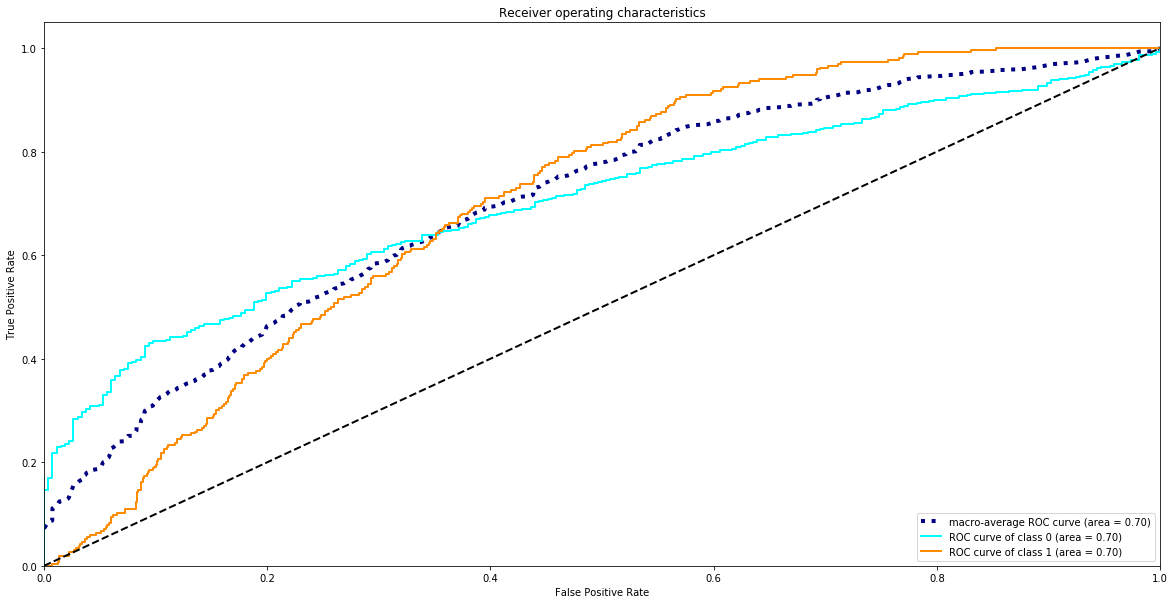

In [51]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nrclasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nrclasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nrclasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nrclasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

In [52]:
from tensorflow.keras.models import load_model

model = load_model('Model-18-0.0379-0.9856-0.4761-0.9134.hdf5')

OSError: SavedModel file does not exist at: Model-18-0.0379-0.9856-0.4761-0.9134.hdf5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
#type(test_generator1)
#test_generator1.filenames
#test_generator1.labels
#test_generator1.class()
#dir(test_generator1)

#print(test_generator1.get_classes)
